In [49]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import shap


C:\Users\Poble\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<center><h1> MCD - Ciencia de Datos Responsable </h1><center>
<center><h2> Tarea 3: Modelos interpretables y xAI <h2><center>    

    
## Instrucciones:

- La siguiente tarea es **individual**.
- La calificación de esta tarea se hará de forma **manual**, es decir, esta tarea no cuenta con test cases automáticos. Es por esto que al hacer entrega de su tarea podrá ver una calificación de "0%" y "Aprobado", independiente del contenido de su notebook.
- Cuenta con intentos ilimitados para el envío de su tarea.
- Ante cualquier duda o consulta pueden comunicarse a través de Foros o Salesforce.

In [3]:
df = pd.read_csv('adult_data.csv')
df.head()

age  workclass     education  education-num      marital-status  \
0  25.0    Private          11th            7.0       Never-married   
1  38.0    Private       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  Some-college           10.0  Married-civ-spouse   
4  34.0    Private          10th            6.0       Never-married   

          occupation   relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black  Male           0.0           0.0   
1    Farming-fishing        Husband  White  Male           0.0           0.0   
2    Protective-serv        Husband  White  Male           0.0           0.0   
3  Machine-op-inspct        Husband  Black  Male        7688.0           0.0   
4      Other-service  Not-in-family  White  Male           0.0           0.0   

   hours-per-week native-country income  
0            40.0  United-States  <=50K  
1            50.0  United-States  <=50K  
2            40.0  United-States   >50K  
3            40.0  United-States   >50K  
4            30.0  United-States  <=50K

### Pregunta 1: Preprocese los datos de Census Income Dataset. Luego, entrene un árbol de decisión y evalúe este modelo desde la perspectiva de la interpretabilidad global. Utilice tanto tree_plot como un gráfico de la importancia de las features (3 ptos).

**Instrucciones adicionales:**

- Haga uso de los métodos que le provee el mismo modelo (intrinsicamente interpretable).


# PREGUNTA 1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45222 non-null  float64
 1   workclass       45222 non-null  object 
 2   education       45222 non-null  object 
 3   education-num   45222 non-null  float64
 4   marital-status  45222 non-null  object 
 5   occupation      45222 non-null  object 
 6   relationship    45222 non-null  object 
 7   race            45222 non-null  object 
 8   sex             45222 non-null  object 
 9   capital-gain    45222 non-null  float64
 10  capital-loss    45222 non-null  float64
 11  hours-per-week  45222 non-null  float64
 12  native-country  45222 non-null  object 
 13  income          45222 non-null  object 
dtypes: float64(5), object(9)
memory usage: 4.8+ MB


In [5]:
# Haremos el arbol de decision de nuevo, pero eliminaremos algunas columnas de df para ver si el arbol cambia 
dataset = df.copy()
dataset.head()

age  workclass     education  education-num      marital-status  \
0  25.0    Private          11th            7.0       Never-married   
1  38.0    Private       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  Some-college           10.0  Married-civ-spouse   
4  34.0    Private          10th            6.0       Never-married   

          occupation   relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black  Male           0.0           0.0   
1    Farming-fishing        Husband  White  Male           0.0           0.0   
2    Protective-serv        Husband  White  Male           0.0           0.0   
3  Machine-op-inspct        Husband  Black  Male        7688.0           0.0   
4      Other-service  Not-in-family  White  Male           0.0           0.0   

   hours-per-week native-country income  
0            40.0  United-States  <=50K  
1            50.0  United-States  <=50K  
2            40.0  United-States   >50K  
3            40.0  United-States   >50K  
4            30.0  United-States  <=50K

In [6]:
dataset = dataset.drop(['education', 'native-country', 'workclass', 'occupation', 'race', 'sex',], axis=1)

In [7]:
dataset.head()

age  education-num      marital-status   relationship  capital-gain  \
0  25.0            7.0       Never-married      Own-child           0.0   
1  38.0            9.0  Married-civ-spouse        Husband           0.0   
2  28.0           12.0  Married-civ-spouse        Husband           0.0   
3  44.0           10.0  Married-civ-spouse        Husband        7688.0   
4  34.0            6.0       Never-married  Not-in-family           0.0   

   capital-loss  hours-per-week income  
0           0.0            40.0  <=50K  
1           0.0            50.0  <=50K  
2           0.0            40.0   >50K  
3           0.0            40.0   >50K  
4           0.0            30.0  <=50K

In [8]:
# Con estos datos eliminados, volvemos a entrenar el modelo y a visualizar el arbol de decision 
X = dataset.drop('income', axis=1)
y = dataset['income']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# sin normalizacion
model_2 = DecisionTreeClassifier()
model_2.fit(X_train, y_train)

print('Test score: ', model_2.score(X_test, y_test))



Test score:  0.8326147042564953


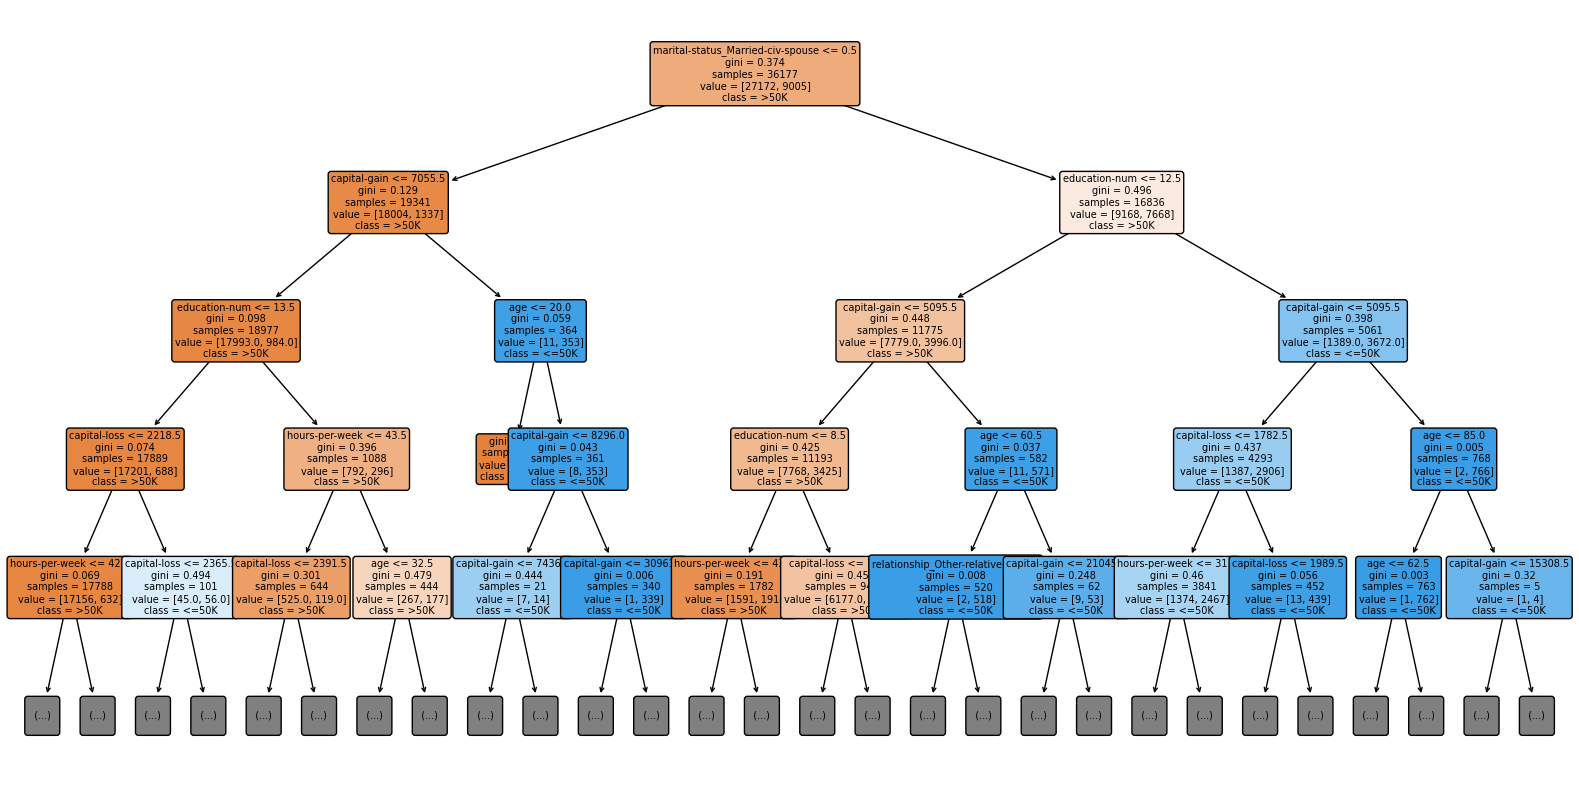

In [9]:
# Arbol de decision graficado
plt.figure(figsize=(20, 10))
plot_tree(model_2, filled=True, rounded = True, feature_names=X.columns, max_depth=4, class_names =[">50K", "<=50K"], fontsize=7)
plt.show()


In [10]:
model_2.feature_importances_

array([0.16134074, 0.18366007, 0.16050276, 0.0607356 , 0.11364225,
       0.00474634, 0.00055839, 0.28066839, 0.00160824, 0.00390965,
       0.00204202, 0.00110339, 0.00648973, 0.00425313, 0.00325711,
       0.0019457 , 0.00219724, 0.00733926])

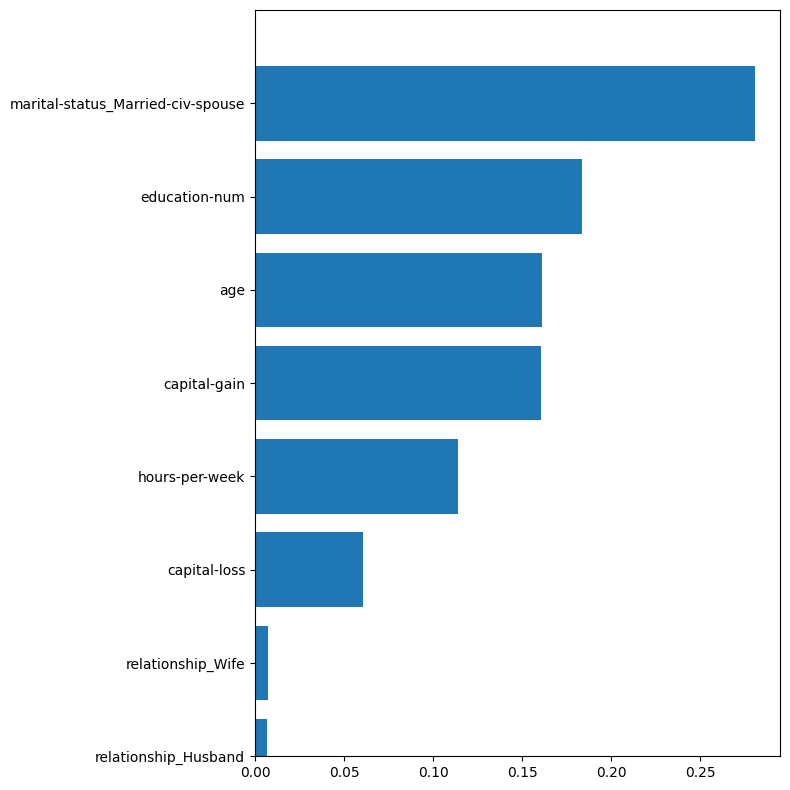

In [11]:
# Visualizacion del feature importance
importance_sorted_idx = np.argsort(model_2.feature_importances_)
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.barh(range(0, 8), model_2.feature_importances_[importance_sorted_idx][-8:], height=0.8)
ax.set_yticks(range(0, 8))
ax.set_yticklabels(X.columns[importance_sorted_idx][-8:])
ax.set_ylim((0, len(model_2.feature_importances_[-8:])))
fig.tight_layout()
plt.show()



En este grafico estan los 8 atributos que provocan la mayor disminucion del gini score.

### Pregunta 2: Entrene otro modelo (que no sea interpretable) y realice el procedimiento necesario para obtener explicabilidad local de este modelo utilizando LIME. Obtenga las explicaciones para las predicciones de 3 registros de los datos de entrenamiento. Comente sus resultados (3 ptos).

**Instrucciones adicionales:**

- Recuerde el uso de LabelEncoder en el pre-procesamiento de sus datos.

In [12]:
# Haremos un copy de df 
df_lime = df.copy()
df_lime.head()


age  workclass     education  education-num      marital-status  \
0  25.0    Private          11th            7.0       Never-married   
1  38.0    Private       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  Some-college           10.0  Married-civ-spouse   
4  34.0    Private          10th            6.0       Never-married   

          occupation   relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black  Male           0.0           0.0   
1    Farming-fishing        Husband  White  Male           0.0           0.0   
2    Protective-serv        Husband  White  Male           0.0           0.0   
3  Machine-op-inspct        Husband  Black  Male        7688.0           0.0   
4      Other-service  Not-in-family  White  Male           0.0           0.0   

   hours-per-week native-country income  
0            40.0  United-States  <=50K  
1            50.0  United-States  <=50K  
2            40.0  United-States   >50K  
3            40.0  United-States   >50K  
4            30.0  United-States  <=50K

In [13]:
df_lime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45222 non-null  float64
 1   workclass       45222 non-null  object 
 2   education       45222 non-null  object 
 3   education-num   45222 non-null  float64
 4   marital-status  45222 non-null  object 
 5   occupation      45222 non-null  object 
 6   relationship    45222 non-null  object 
 7   race            45222 non-null  object 
 8   sex             45222 non-null  object 
 9   capital-gain    45222 non-null  float64
 10  capital-loss    45222 non-null  float64
 11  hours-per-week  45222 non-null  float64
 12  native-country  45222 non-null  object 
 13  income          45222 non-null  object 
dtypes: float64(5), object(9)
memory usage: 4.8+ MB


In [14]:
# Crear columna de age-cat para discretizar la edad y se dividira en joven y adulto
df_lime['age_cat'] = pd.cut(df_lime['age'], bins=[0, 30, 100], labels=['joven', 'adulto'])
df_lime.drop('age', axis=1, inplace=True)


In [15]:
df_lime.head()

workclass     education  education-num      marital-status  \
0    Private          11th            7.0       Never-married   
1    Private       HS-grad            9.0  Married-civ-spouse   
2  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
3    Private  Some-college           10.0  Married-civ-spouse   
4    Private          10th            6.0       Never-married   

          occupation   relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black  Male           0.0           0.0   
1    Farming-fishing        Husband  White  Male           0.0           0.0   
2    Protective-serv        Husband  White  Male           0.0           0.0   
3  Machine-op-inspct        Husband  Black  Male        7688.0           0.0   
4      Other-service  Not-in-family  White  Male           0.0           0.0   

   hours-per-week native-country income age_cat  
0            40.0  United-States  <=50K   joven  
1            50.0  United-States  <=50K  adulto  
2            40.0  United-States   >50K   joven  
3            40.0  United-States   >50K  adulto  
4            30.0  United-States  <=50K  adulto

In [16]:
df_lime['income'] = df_lime['income'].map({'<=50K': 0, '>50K': 1})
df_lime['age_cat'] = df_lime['age_cat'].map({'joven': 0, 'adulto': 1})
df_lime['sex'] = df_lime['sex'].map({'Male': 1, 'Female': 0})


In [17]:
df_lime.head()


workclass     education  education-num      marital-status  \
0    Private          11th            7.0       Never-married   
1    Private       HS-grad            9.0  Married-civ-spouse   
2  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
3    Private  Some-college           10.0  Married-civ-spouse   
4    Private          10th            6.0       Never-married   

          occupation   relationship   race  sex  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black    1           0.0           0.0   
1    Farming-fishing        Husband  White    1           0.0           0.0   
2    Protective-serv        Husband  White    1           0.0           0.0   
3  Machine-op-inspct        Husband  Black    1        7688.0           0.0   
4      Other-service  Not-in-family  White    1           0.0           0.0   

   hours-per-week native-country  income age_cat  
0            40.0  United-States       0       0  
1            50.0  United-States       0       1  
2            40.0  United-States       1       0  
3            40.0  United-States       1       1  
4            30.0  United-States       0       1

In [18]:

df_lime.head()

workclass     education  education-num      marital-status  \
0    Private          11th            7.0       Never-married   
1    Private       HS-grad            9.0  Married-civ-spouse   
2  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
3    Private  Some-college           10.0  Married-civ-spouse   
4    Private          10th            6.0       Never-married   

          occupation   relationship   race  sex  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black    1           0.0           0.0   
1    Farming-fishing        Husband  White    1           0.0           0.0   
2    Protective-serv        Husband  White    1           0.0           0.0   
3  Machine-op-inspct        Husband  Black    1        7688.0           0.0   
4      Other-service  Not-in-family  White    1           0.0           0.0   

   hours-per-week native-country  income age_cat  
0            40.0  United-States       0       0  
1            50.0  United-States       0       1  
2            40.0  United-States       1       0  
3            40.0  United-States       1       1  
4            30.0  United-States       0       1

In [19]:
# Separamos X e Y

X = df_lime.loc[:, df_lime.columns != 'income']
y = df_lime.loc[:, df_lime.columns == 'income']

y

income
0           0
1           0
2           1
3           1
4           0
...       ...
45217       0
45218       1
45219       0
45220       0
45221       1

[45222 rows x 1 columns]

In [20]:
# Quiero ver el tipo de columnas en X
X.dtypes

workclass           object
education           object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                  int64
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
age_cat           category
dtype: object

In [21]:
# Utilizamos el Label Encoder
to_encode = X.select_dtypes(include=['object'])
encoders = {}

for catcol in to_encode.columns:
    encoder = LabelEncoder()
    X[catcol] = encoder.fit_transform(X[catcol])
    encoders[catcol] = encoder

X.head()

C:\Users\Poble\AppData\Local\Temp\ipykernel_25148\4011710121.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[catcol] = encoder.fit_transform(X[catcol])
C:\Users\Poble\AppData\Local\Temp\ipykernel_25148\4011710121.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[catcol] = encoder.fit_transform(X[catcol])
C:\Users\Poble\AppData\Local\Temp\ipykernel_25148\4011710121.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

workclass  education  education-num  marital-status  occupation  \
0          2          1            7.0               4           6   
1          2         11            9.0               2           4   
2          1          7           12.0               2          10   
3          2         15           10.0               2           6   
4          2          0            6.0               4           7   

   relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
0             3     2    1           0.0           0.0            40.0   
1             0     4    1           0.0           0.0            50.0   
2             0     4    1           0.0           0.0            40.0   
3             0     2    1        7688.0           0.0            40.0   
4             1     4    1           0.0           0.0            30.0   

   native-country age_cat  
0              38       0  
1              38       1  
2              38       0  
3              38       1  
4              38       1

In [22]:
to_encode

workclass     education      marital-status         occupation  \
0           Private          11th       Never-married  Machine-op-inspct   
1           Private       HS-grad  Married-civ-spouse    Farming-fishing   
2         Local-gov    Assoc-acdm  Married-civ-spouse    Protective-serv   
3           Private  Some-college  Married-civ-spouse  Machine-op-inspct   
4           Private          10th       Never-married      Other-service   
...             ...           ...                 ...                ...   
45217       Private    Assoc-acdm  Married-civ-spouse       Tech-support   
45218       Private       HS-grad  Married-civ-spouse  Machine-op-inspct   
45219       Private       HS-grad             Widowed       Adm-clerical   
45220       Private       HS-grad       Never-married       Adm-clerical   
45221  Self-emp-inc       HS-grad  Married-civ-spouse    Exec-managerial   

        relationship   race native-country  
0          Own-child  Black  United-States  
1            Husband  White  United-States  
2            Husband  White  United-States  
3            Husband  Black  United-States  
4      Not-in-family  White  United-States  
...              ...    ...            ...  
45217           Wife  White  United-States  
45218        Husband  White  United-States  
45219      Unmarried  White  United-States  
45220      Own-child  White  United-States  
45221           Wife  White  United-States  

[45222 rows x 7 columns]

In [23]:
# Datos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=908)

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier()

In [25]:
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred)

0.6706904876871077

In [26]:
X_train

workclass  education  education-num  marital-status  occupation  \
28441          2         11            9.0               4           0   
33791          2         11            9.0               2           2   
21441          2          9           13.0               2          11   
9154           2         12           14.0               2           9   
23791          2         15           10.0               2           2   
...          ...        ...            ...             ...         ...   
6456           2         11            9.0               2           6   
11196          1          8           11.0               4          12   
25904          1          7           12.0               4           0   
35322          2          9           13.0               2           9   
18538          2         15           10.0               1          10   

       relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
28441             1     4    0           0.0           0.0            40.0   
33791             0     4    1           0.0        1579.0            40.0   
21441             0     4    1           0.0           0.0            40.0   
9154              5     4    0           0.0        1902.0            45.0   
23791             0     4    1           0.0           0.0            40.0   
...             ...   ...  ...           ...           ...             ...   
6456              0     4    1           0.0           0.0            40.0   
11196             1     4    0           0.0        1564.0            72.0   
25904             4     2    0           0.0           0.0            40.0   
35322             0     4    1           0.0           0.0            50.0   
18538             0     4    1           0.0           0.0            40.0   

       native-country age_cat  
28441              38       0  
33791              38       0  
21441              38       1  
9154               38       1  
23791              38       1  
...               ...     ...  
6456               38       1  
11196              38       0  
25904              38       0  
35322              38       1  
18538              38       0  

[36177 rows x 13 columns]

In [27]:
object_features = [X_train.columns.get_loc(col) for col in to_encode.columns]
object_names = {i: encoders[X_train.columns[i]].classes_ for i in object_features}

In [28]:
object_features

[0, 1, 3, 4, 5, 6, 11]

In [29]:
object_names

{0: array(['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'], dtype=object),
 1: array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 3: array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 4: array(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty',
        'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'],
       dtype=object),
 5: array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 6: array(['Amer-Indian-Eskimo', 'Asian-Pac-Isl

In [30]:
# Ahora utilizaremos LIME

explainer = LimeTabularExplainer(X_train.values,
                                 mode='classification',
                                 feature_names=X_train.columns.to_list(),
                                 categorical_features=object_features,
                                 categorical_names=object_names,
                                 discretize_continuous=True,
                                 discretizer='decile',
                                 kernel_width=5)

C:\Users\Poble\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


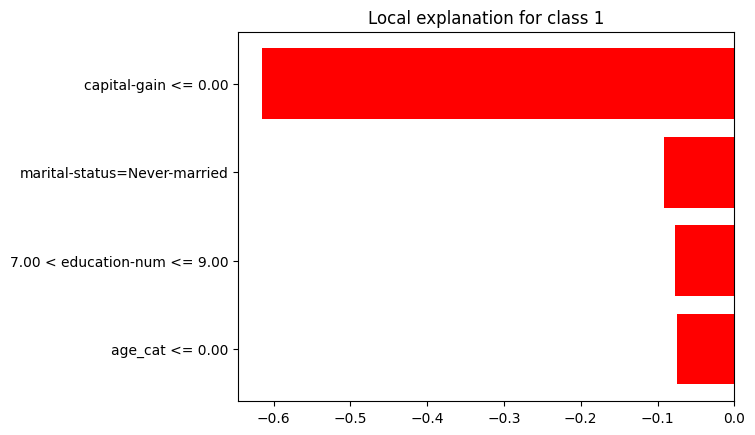

C:\Users\Poble\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


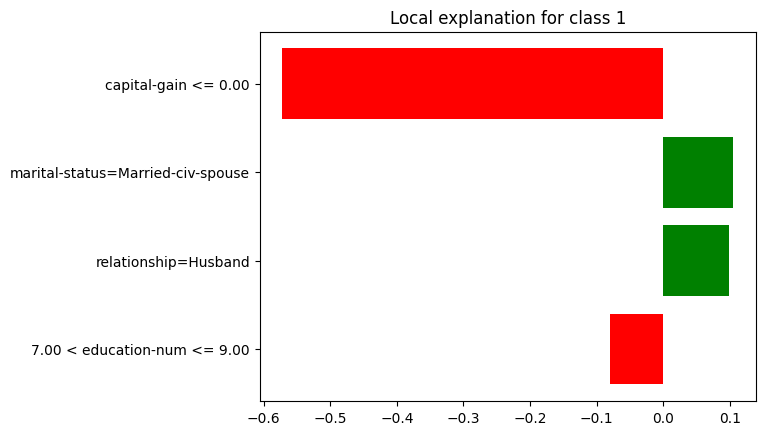

C:\Users\Poble\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


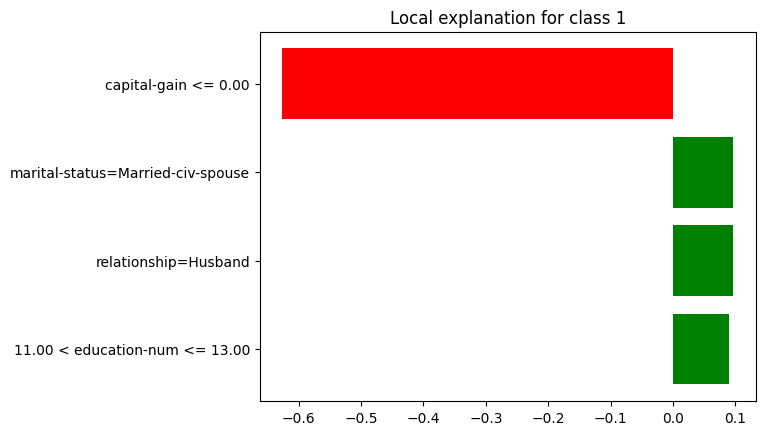

In [39]:
lista = []
for i in range(3):
    exp = explainer.explain_instance(X_train.iloc[i,:], rf.predict_proba, num_features=4)
    exp.show_in_notebook(show_table=True, show_all=False)
    exp.as_pyplot_figure()
    lista.append(pd.DataFrame(exp.as_list(),columns=['Feature','Contribution']))
    plt.show()

In [48]:
lista

[                        Feature  Contribution
 0          capital-gain <= 0.00     -0.615178
 1  marital-status=Never-married     -0.091734
 2  7.00 < education-num <= 9.00     -0.076924
 3               age_cat <= 0.00     -0.075126,
                              Feature  Contribution
 0               capital-gain <= 0.00     -0.571990
 1  marital-status=Married-civ-spouse      0.105214
 2               relationship=Husband      0.099428
 3       7.00 < education-num <= 9.00     -0.079965,
                              Feature  Contribution
 0               capital-gain <= 0.00     -0.626275
 1  marital-status=Married-civ-spouse      0.096461
 2               relationship=Husband      0.095918
 3     11.00 < education-num <= 13.00      0.090022]

In [50]:
X_train.head()

workclass  education  education-num  marital-status  occupation  \
28441          2         11            9.0               4           0   
33791          2         11            9.0               2           2   
21441          2          9           13.0               2          11   
9154           2         12           14.0               2           9   
23791          2         15           10.0               2           2   

       relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
28441             1     4    0           0.0           0.0            40.0   
33791             0     4    1           0.0        1579.0            40.0   
21441             0     4    1           0.0           0.0            40.0   
9154              5     4    0           0.0        1902.0            45.0   
23791             0     4    1           0.0           0.0            40.0   

       native-country age_cat  
28441              38       0  
33791              38       0  
21441              38       1  
9154               38       1  
23791              38       1

In [51]:
rf

RandomForestClassifier()

# Parte con Shap aun no se si es necesario.

In [52]:
explainer_shap = shap.Explainer(rf.predict_proba, X_train)
shap_values = explainer_shap(X_train[:100])

PermutationExplainer explainer: 101it [00:57,  1.67it/s]                         


In [53]:
shap_values = shap_values[..., 1]


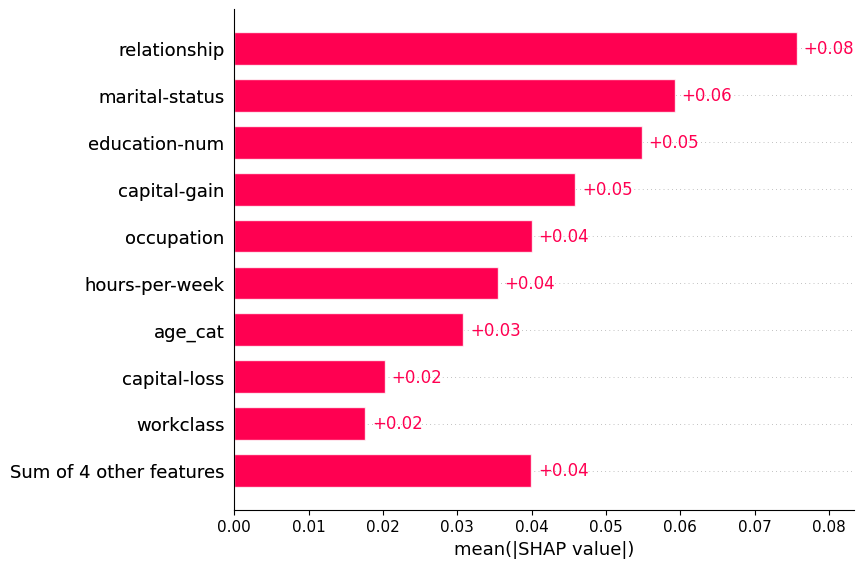

In [55]:
# grafico de barras
shap.plots.bar(shap_values)

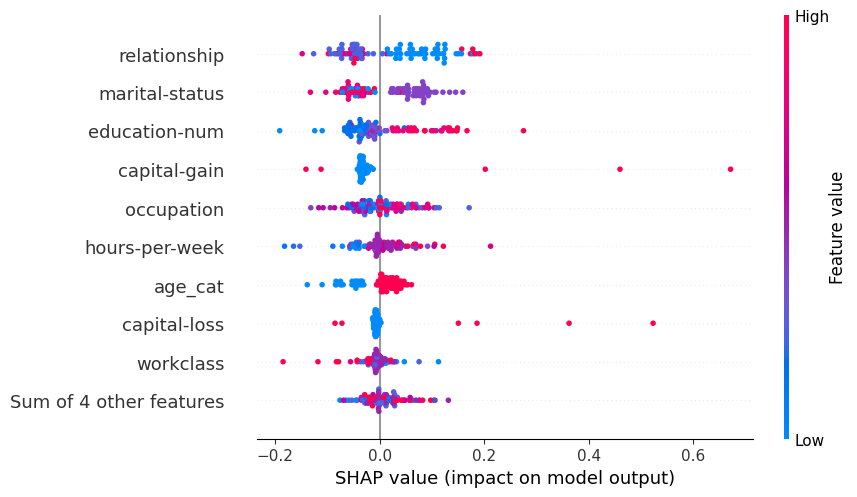

In [57]:
shap.plots.beeswarm(shap_values)

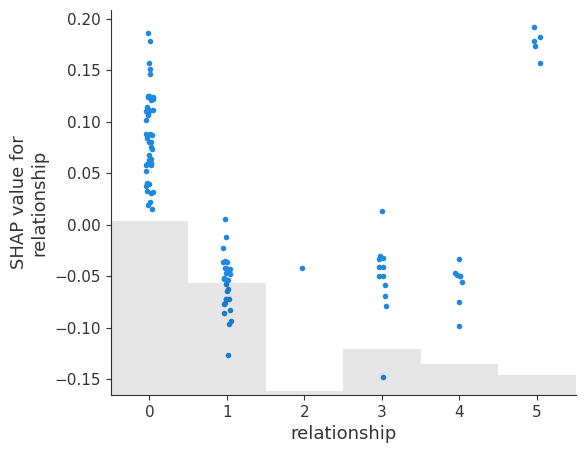

In [58]:
shap.plots.scatter(shap_values[:, 'relationship'])

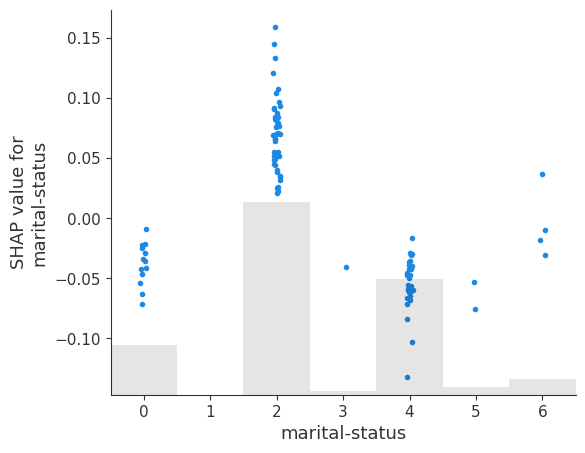

In [60]:
shap.plots.scatter(shap_values[:, 'marital-status'])

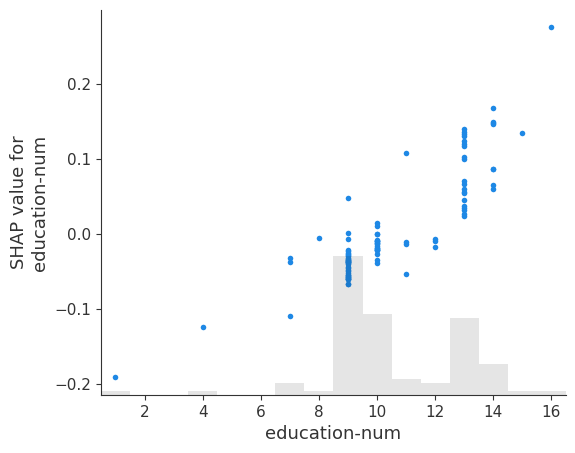

In [61]:
shap.plots.scatter(shap_values[:, 'education-num'])

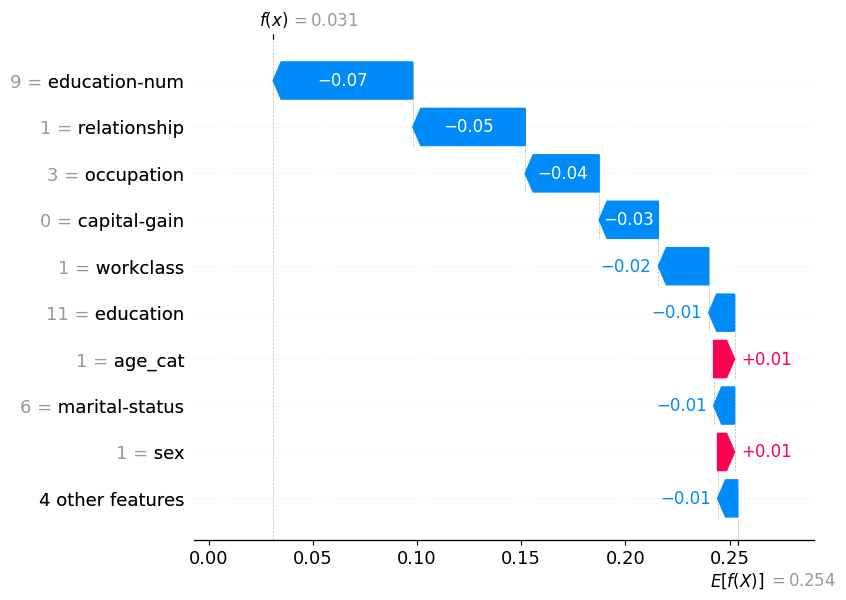

In [62]:
shap.plots.waterfall(shap_values[99])